## Data loading and pre processing

An initial preliminary exploration of the data excel file showed that the data contains non-numeric values. Therefore, before importing it to a numpy array, a Pandas dataframe is necessary to load the initial data.

In [1]:
import pandas as pd
data = pd.read_excel('Data.xlsx')

As first step, we are going to remove all the variables that contain no information.

In [2]:
num = data.nunique()
valid = num  > 1
data_val = data.loc[:, valid]
data_val.columns

Index(['localizedtimestamp', 'plantlocalname', 'workcenter', 'recipe',
       'set_batch', 'actual_batch', 'mixing_time', 'npttime',
       'mixingcycletime', 'setuptime', 'idle_time', 'nptpl', 'loading_time',
       'nptcs', 'drop_door_open_time', 'discharge_door_dwell_time',
       'manualinterruption', 'drop_door_close_time', 'ram_down_time',
       'ram_up_time', 'set_dump_temperature', 'batch_temperature',
       'set_dump_energy', 'mix_energy', 'total_weight', 'set_polymer_weight_1',
       'actual_polymer_weight1', 'set_polymer_weight_2',
       'actual_polymer_weight_3', 'set_polymer_weight_3',
       'actual_polymer_weight_2', 'set_polymer_weight_4',
       'actual_polymer_weight_4', 'carbonchargingrate (kg/sec)',
       'carbon_charging_time', 'carbon_weighing_time',
       'carbon_black_set_weight', 'carbon_black_act_weight', 'oil_set_weight',
       'oil_actual_weight', 'oil_charging_time', 'oil_weighing_time',
       'processoil_dust_stopinkg', 'lubeoil_dust_stop inkg', 'u

### Removal of data with 'expert knowledge'

Some variables still present are probably meaningless, or even false predictors. Thus, we want to remove them before even going forward. To do this, some knowledge of the data would be necessary. I am going to make some decisions based on the name of the variables. These are assumptions that may be wrong which may change the final results. Under normal circumstances, I would get more information before proceeding, but considering this is an exercise I will just proceed acknowledging that there may be mistakes.
The features to be removed are the following:
* localiozedtimestamp: While the timestamp may be a meaningful information (maybe during the morning due to the lower temperature, the machine takes longer to start up), the number of confounding factors that this may hide is dangerous. Thus, I would integrate this feature only in the future if I am certain that I can control those factors. Also, the variability of this feature may lead to overfitting quite easily.
* ucttimestamp: Idem.
* Shiftdate: Idem.
* Workcenter: Seems to be a different format for plantlocalname
* set_batch: From the name I am assuming this is the schedule batch while the actual_batch would be the actual batch. A correlation between set_batch and our output could be misleading as probably would not indicate causality. Thus, I consider it better to remove this feature.
* setuptime: This seems to be the time required to set up the first time a specific recipe. This is not considered towards the mixingcycletime, so the values in this feature could be considered outliers when different from 0. Thus, this feature can be removed.
* idle_time: This only happens when manual interruption is activated. To study the efficiency of the recipe, this is probably not relevant and may introduce outliers in the same way as setuptime. A different analysis, looking to which recepies create more problems, could use this variable along with interviews with those that activated the manual interruption.
* manual_interruption: Idem.
* set_dump_temperature: Similar to setbatch, this is just the theoretical value, but we have the actual value used. This feature could be used to measure the accuracy of the loading process, but should not be relevant for the efficiency measures.
* set_dump_energy: Idem.
* set_polymer_weight_[1...4]: Idem.
* oil_set_weight: Idem.
* carbon_black_set_weight: Idem.
* tss: It seems to indicate the use of lubeoil and processoil.

This leave us with a total of 32 features. Some of them are actually completely dependent from others (total_weight, mixingcicletime, carbonchargingrate), but we will leave them for now.

In [3]:
d_col = ['localizedtimestamp', 'utctimestamp', 'Shiftdate', 'workcenter', 'setuptime', 'idle_time', 'set_dump_temperature', 'set_dump_temperature', 'set_dump_energy', 'set_polymer_weight_1', 'set_polymer_weight_2', 'set_polymer_weight_3', 'set_polymer_weight_4', 'carbon_black_set_weight', 'oil_set_weight', 'manualinterruption', 'tss']
data_val = data_val.drop(d_col, axis=1)
data_val.shape

(10998, 32)

### False predictors and dependant variables
The two variables that we want to study are Mixer efficiency, which is the ratio between 'total_weight' and 'mixing_time'. The second variable to study is 'mixingcicletime'. For the first we need to build a regressor, while for the second we need to analyse the most relevant features.
For these two problems, we  are going to exclude the variables  mixing_time and npttime as input features as they may be false predictors. I am assuming that when developing new materials, we are able to control the quantity and distribution of the materials, but it's unknown what the time to 'cook' will be. So, once we deploy the system, we may be able to estimate the efficiency or mixing cycle time from a model that uses as input the combination of materials, but we won't have available to mixing or npttime. If we build a model with these features, it will result in incorrect errors when deployed.

In [4]:
efficiency = data_val['total_weight'] / data_val['mixing_time']
y = data_val['mixingcycletime']
d_col = ['mixingcycletime', 'npttime', 'mixing_time']
data_val = data_val.drop(d_col, axis=1)

### Categorical data
From the remaining features, three are categorical: plantlocalname, recipe, and Shift. Without more information, I will assume that there is no ordinal relationship between the values that they may take, so one-hot encoder will be used for the three features.

In [5]:
data_val = pd.get_dummies(data_val, columns=['plantlocalname', 'recipe', 'Shift'])
data_val.dtypes

set_batch           int64
actual_batch        int64
nptpl             float64
loading_time      float64
nptcs             float64
                   ...   
recipe_XMT6404      uint8
recipe_XMT6405      uint8
Shift_A             uint8
Shift_B             uint8
Shift_C             uint8
Length: 107, dtype: object

After this process we are left with 108 features: 27 for different values, 2 for the plant (this could be reduced to 1), 3 for the shifts, and 76 to indicate the recipe. These being extremely sparse features, probably will be removed during the automatic feature selection.

In [6]:
import numpy as np
x = data_val.to_numpy()
y = y.to_numpy()
eff = efficiency.to_numpy()

## Exploratory Data Analysis


In [7]:
# Calculating the correlation with binary variables can be missleading
nFeat = 26
corr = np.corrcoef(x[:, :nFeat].T)
for i in range(nFeat):
    corr[i, i] = 0

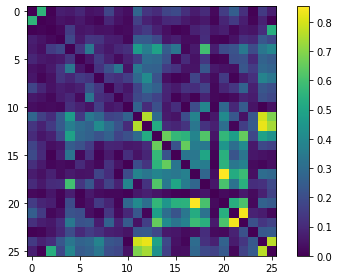

In [8]:
from matplotlib import pyplot as plt
plt.imshow(np.abs(corr))
plt.tight_layout()
plt.colorbar()
plt.show()

In [9]:
names = list(data_val.columns[:nFeat])
print('Above 90%:')
for i in range(nFeat):
    for j in range(i+1, nFeat):
        if corr[i,j] >= 0.9:
            print('%s - %s' % (names[i], names[j]))
print('\nAbove 80%:')
for i in range(nFeat):
    for j in range(i+1, nFeat):
        if corr[i,j] >= 0.8 and corr[i, j] < 0.9:
            print('%s - %s' % (names[i], names[j]))
print('\nAbove 70%:')
for i in range(nFeat):
    for j in range(i+1, nFeat):
        if corr[i,j] >= 0.7 and corr[i, j] < 0.8:
            print('%s - %s' % (names[i], names[j]))
print('\nAbove 60%:')
for i in range(nFeat):
    for j in range(i+1, nFeat):
        if corr[i,j] >= 0.6 and corr[i, j] < 0.7:
            print('%s - %s' % (names[i], names[j]))

Above 90%:

Above 80%:
carbonchargingrate (kg/sec) - carbon_black_act_weight
oil_actual_weight - oil_charging_time

Above 70%:
mix_energy - total_weight
processoil_dust_stopinkg - lubeoil_dust_stop inkg

Above 60%:
actual_polymer_weight_3 - actual_polymer_weight_4
carbon_charging_time - carbon_black_act_weight
carbon_black_act_weight - oil_charging_time


These initial results seem logical, there are no features correlated with 90%. Other high correlation are between features that make sense to be correlated from the logical point of view.
There is the exception 'mix_energy', which I didn't identify as a false predictor initially, but it may be a false predictor as well. If this feature is actually the total energy used (calculated afterwards), then using it for predicting the performance would be misleading. Thus, to be on the safe side I will remove this feature. Again, this is something that would require more information about the process before making this kind of decisions.

In [10]:
id = names.index('mix_energy')
names.remove('mix_energy')
x = np.delete(x, id, 1)
nFeat -= 1

### Distribution of variables
The next analysis that I want to perform is to check the correlation between each one of the input variables and the outputs (efficiency and time). I will perform the analysis for each target independently.

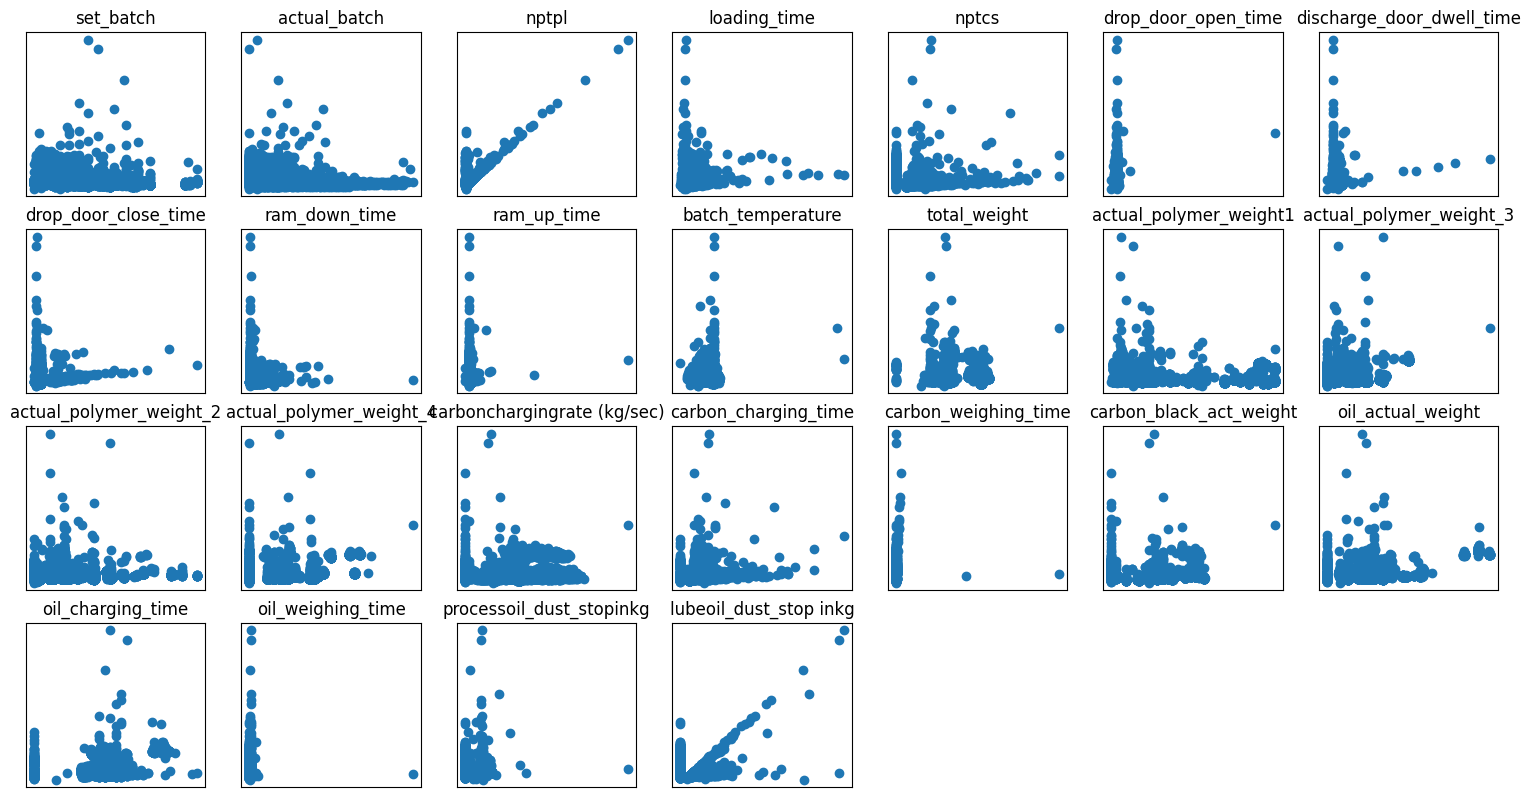

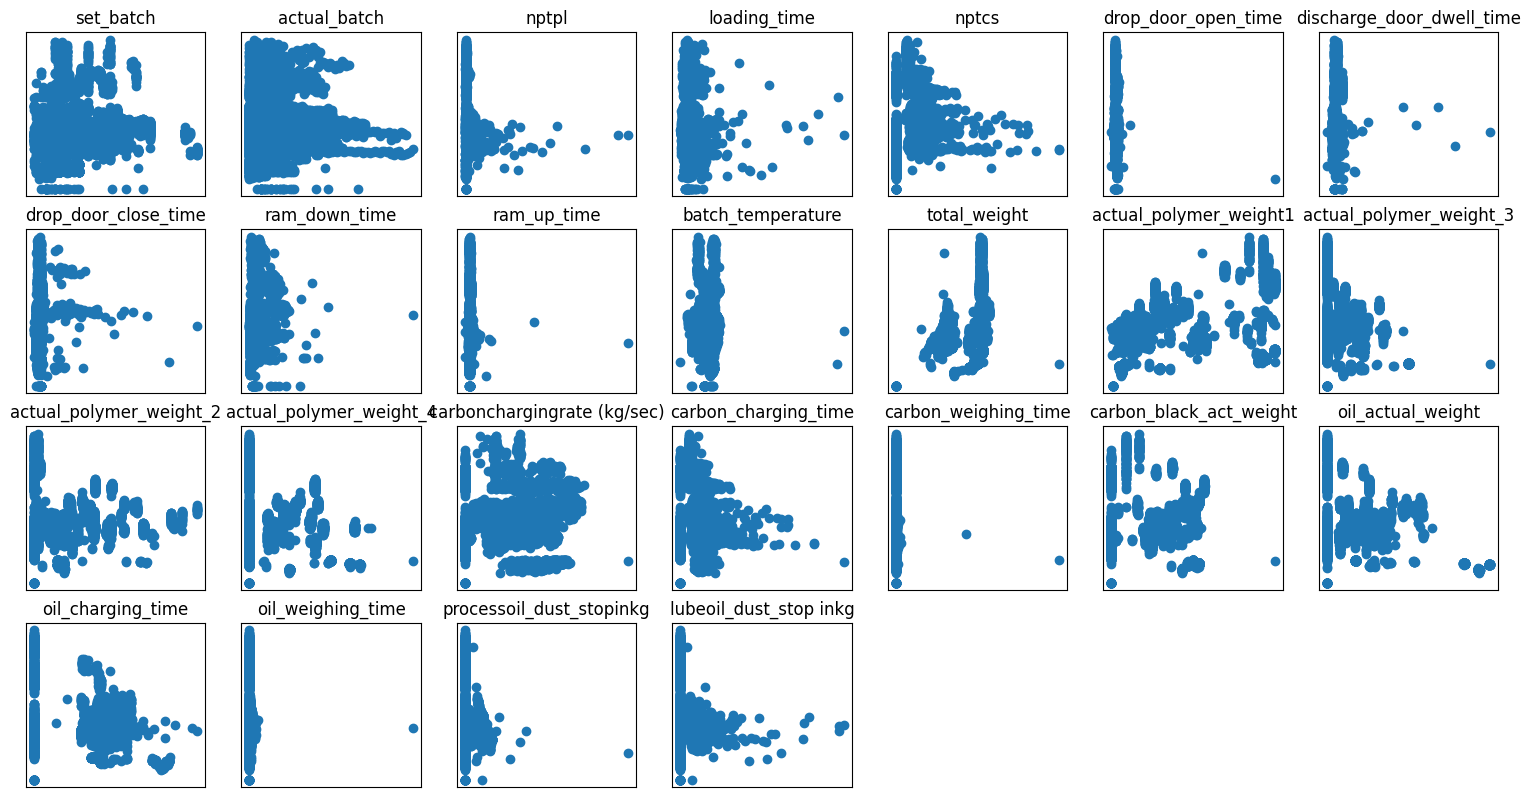

In [11]:
dpi = 100
figsize =(1900 / dpi, 1000 / dpi)

plt.figure(1, figsize, dpi=dpi)
for i in range(nFeat):
    plt.subplot(4, 7, i + 1)
    plt.scatter(x[:, i], y)
    plt.title(names[i])
    plt.xticks([], [])
    plt.yticks([], [])
plt.show()

plt.figure(2, figsize, dpi=dpi)
for i in range(nFeat):
    plt.subplot(4, 7, i + 1)
    plt.scatter(x[:, i], eff)
    plt.title(names[i])
    plt.xticks([], [])
    plt.yticks([], [])
plt.show()

Time:
 The time to complete seems to be highly correlated with nptpl and lubeoil_dust_stopinkg. It seems that nptpl may be related with npttime that was removed as false predictor before. Before performing any prediction or analysis on this variable, I will remove this feature. The second feature, it may be the time at which the lubeoil dust stopped,  if this is something that is not set during the initialization, using this variable (and I am assuming processoil_dust_stoping) would lead to misleading results. Thus, they will be removed as well.

Efficiency:
 For this variable it doesn't seem to be any false predictors. The most promising features are polymer 1 weight and carbon chargin rate. Both of them seem sensible features for this problem.

## Prediction of the efficiency


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA

In [13]:
class ThressholdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, qoffset=1.5):
        self.qoffset = qoffset
        self._pthr = 0
        self._nthr = 0

    def fit(self, X, y=None):
        q1 = np.percentile(X, 25, axis=0)
        q3 = np.percentile(X, 75, axis=0)
        self._nthr = q1 - self.qoffset*(q3 - q1)
        self._pthr = q3 + self.qoffset*(q3 - q1)
        return self

    def transform(self, X, y=None):
        for i in range(X.shape[1]):
            X[:, i] = np.clip(X[:, i], self._nthr[i], self._pthr[i])
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, y)

class BaseFeature(BaseEstimator, TransformerMixin):
    def __init__(self, all_feats= True, norm_weight = True):
        self.all_feats = all_feats
        self.norm_weight = norm_weight
        self.polymer_id = np.arange(12, 16) # The index of the polymer weights
        self.min_feat = 25 # The number of non-binary features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.norm_weight:
            sum = np.sum(X[:, self.polymer_id], 1)
            val = sum != 0
            for i in range(X.shape[0]):
                if val[i]:
                    X[i, self.polymer_id] /= sum[i]
        if not self.all_feats:
            X = X[:, :self.min_feat]
        return X

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X, y)

In [20]:
cv = KFold(shuffle=True) # The data is groupped by recepy, so we want to shuffle
ssc = StandardScaler()
tsc = ThressholdScaler()
bsfeat = BaseFeature()
pipe = Pipeline([('base', bsfeat), ('outlier', tsc), ('scaler', ssc), ('pca', PCA()), ('clf', Lasso())])
param_grid = dict(base__all_feats=[True, False],
                  base__norm_weight =[True, False],
                  pca = ['passthrough',  PCA(0.9)],
                  clf__alpha = np.logspace(-8, 10, 20))
grid_search = GridSearchCV(pipe, param_grid, n_jobs=24)
metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
res = cross_validate(grid_search, x, eff, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv)

In [21]:
for clf in res['estimator']:
    print(clf.best_estimator_)
res['estimator']=[]
res['score_time'] = []
res['fit_time'] = []
for k in res.keys():
    if len(res[k]):
        res[k] = np.mean(res[k])
res

Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Lasso(alpha=0.004832930238571752))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Lasso(alpha=0.004832930238571752))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Lasso(alpha=0.004832930238571752))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Lasso(alpha=0.004832930238571752))])
Pipeline(steps=[('base', BaseFeature(norm_weight

{'fit_time': [],
 'score_time': [],
 'estimator': [],
 'test_neg_mean_squared_error': -0.3563935071965839,
 'train_neg_mean_squared_error': -0.35347317303537207,
 'test_neg_mean_absolute_error': -0.4079134653182872,
 'train_neg_mean_absolute_error': -0.4062389988250833,
 'test_r2': 0.6358047713520465,
 'train_r2': 0.6388590331856654}

In [22]:
pipe = Pipeline([('base', bsfeat), ('outlier', tsc), ('scaler', ssc), ('pca', PCA()), ('clf', Ridge())])
param_grid = dict(base__all_feats=[True, False],
                  base__norm_weight =[True, False],
                  pca = ['passthrough',  PCA(0.9)],
                  clf__alpha = np.logspace(-8, 10, 20))
grid_search = GridSearchCV(pipe, param_grid, n_jobs=24)
metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
res = cross_validate(grid_search, x, eff, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv)

In [23]:
for clf in res['estimator']:
    print(clf.best_estimator_)
res['estimator']=[]
res['score_time'] = []
res['fit_time'] = []
for k in res.keys():
    if len(res[k]):
        res[k] = np.mean(res[k])
res

Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Ridge(alpha=263.6650898730355))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Ridge(alpha=263.6650898730355))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Ridge(alpha=263.6650898730355))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
                ('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('pca', 'passthrough'),
                ('clf', Ridge(alpha=263.6650898730355))])
Pipeline(steps=[('base', BaseFeature(norm_weight=False)),
  

{'fit_time': [],
 'score_time': [],
 'estimator': [],
 'test_neg_mean_squared_error': -0.36194342679449953,
 'train_neg_mean_squared_error': -0.3595888903144645,
 'test_neg_mean_absolute_error': -0.4081404487891209,
 'train_neg_mean_absolute_error': -0.4069130415448046,
 'test_r2': 0.6300455581828295,
 'train_r2': 0.6326023782472652}

As a first approach, we can learn a few things:
* Using normalized polymer weight is a bad idea
* It is better to preserve all the features. This can also be seen by the similar results between Lasso and Ridge.
* PCA is not needed as we have few features already. This is thanks to the previous work.
* Considering that the efficiency values range from 0 to 7, an average error of 0.4 seems good specially considering an r2 score of 0.63. Also, looking at the differences between training and test results, there seems to be no overfitting.

This is our baseline, let's try to improve it with other methods.

In [24]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

pipe = Pipeline([('outlier', tsc), ('scaler', ssc), ('clf', AdaBoostRegressor(DecisionTreeRegressor()))])
param_grid = dict(clf__n_estimators = np.arange(5, 100, 25),
                  clf__learning_rate=np.logspace(-4, 0, 5),
                  clf__base_estimator__max_depth = np.arange(5, 30, 7),
                  clf__base_estimator__min_samples_leaf = [10, 20, 50, 100])
grid_search = GridSearchCV(pipe, param_grid, n_jobs=24)
metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
res = cross_validate(grid_search, x, eff, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv)

In [25]:
for clf in res['estimator']:
    print(clf.best_estimator_)
res['estimator']=[]
res['score_time'] = []
res['fit_time'] = []
for k in res.keys():
    if len(res[k]):
        res[k] = np.mean(res[k])
res

Pipeline(steps=[('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('clf',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=26,
                                                                        min_samples_leaf=50),
                                   n_estimators=30))])
Pipeline(steps=[('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('clf',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=19,
                                                                        min_samples_leaf=20),
                                   n_estimators=30))])
Pipeline(steps=[('outlier', ThressholdScaler()), ('scaler', StandardScaler()),
                ('clf',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=12,
                                                                        min_samples_leaf=20),
                                   n_esti

{'fit_time': [],
 'score_time': [],
 'estimator': [],
 'test_neg_mean_squared_error': -0.02321626687297571,
 'train_neg_mean_squared_error': -0.012155987368791837,
 'test_neg_mean_absolute_error': -0.08637718545827958,
 'train_neg_mean_absolute_error': -0.07287768853715153,
 'test_r2': 0.9763074260220783,
 'train_r2': 0.9875569497415055}

The results using this more advance method are outstanding, indicating that the problem is quite complex and that maybe more complex methods may lead to even better results. We can see that there is no signs of overfitting on the results. The results being this good is suspicious to some extent. However, considering that the dataset is the same used for the simple regression in addition to the nested cross validation method used and the removal of several features initially, reduces the likelihood of these results being false. However, I would suggest a deeper exploration of the results to confirm their validity before implementing them into production.
Under normal circumstances I would implement at least one or two other complex methods and compare their performance. However, due to time limitations I will skip this point. Also, I don't consider necessary, a statistical test comparing the three methods presented as their difference is enormous. In any case, a non-parametric paired Kruskall-Wallis tests could be performed using each of the error predictions for every sample available. So in total >1000.

## Mixing cycle time feature importance
Now, we will explore the importance of each feature for the mixing cycle time. As mentioned before, I will remove lubeoil_dust_stopinkg, processoil_dust_stoping, and nptpl as they may not be reliable.

In [27]:
id = names.index('processoil_dust_stopinkg')
names.remove('processoil_dust_stopinkg')
x = np.delete(x, id, 1)
nFeat -= 1
id = names.index('lubeoil_dust_stop inkg')
names.remove('lubeoil_dust_stop inkg')
x = np.delete(x, id, 1)
nFeat -= 1
id = names.index('nptpl')
names.remove('nptpl')
x = np.delete(x, id, 1)
nFeat -= 1

In [32]:
tsc = ThressholdScaler()
xpost = x.copy()
xpost[:, :nFeat] = tsc.fit_transform(xpost[:, :nFeat])

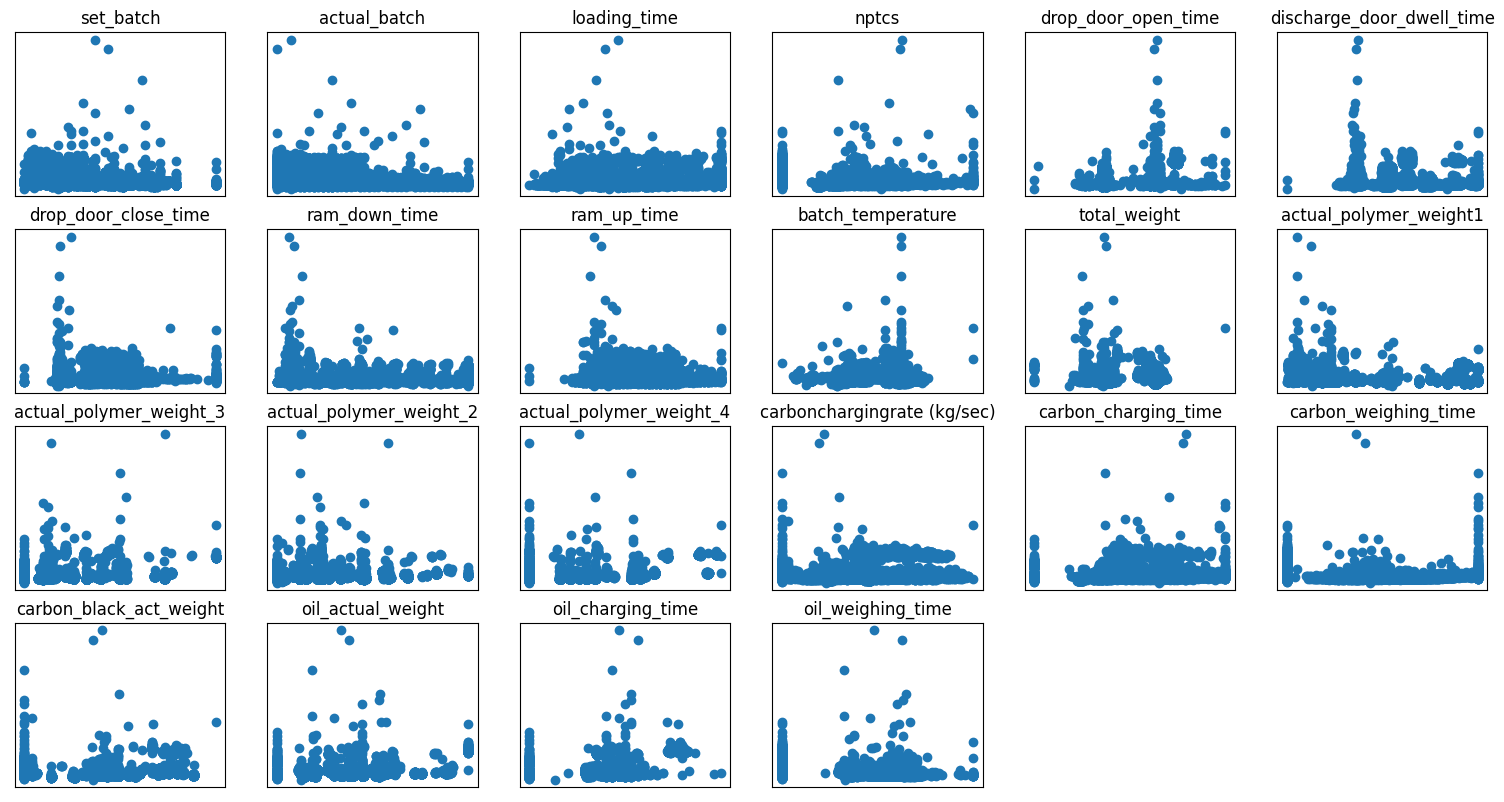

In [34]:
plt.figure(1, figsize, dpi=dpi)
for i in range(nFeat):
    plt.subplot(4, 6, i + 1)
    plt.scatter(xpost[:, i], y)
    plt.title(names[i])
    plt.xticks([], [])
    plt.yticks([], [])
plt.show()

I repeated the plotting after removing the features that I considered to be problematic and removing the outliers.There does not seem to be a strong linear correlation between any of the features and the time. Let's confirm it.

In [39]:
correlation = np.zeros((nFeat, 2))
for i in range(nFeat):
    correlation[i, 0] = np.corrcoef(xpost[:, i], y)[0, 1]
    val = xpost[:, i] != 0
    correlation[i, 1] = np.corrcoef(xpost[val, i], y[val])[0, 1]
    print("%s %.3f %.3f" %(names[i], correlation[i, 0], correlation[i, 1]))

set_batch -0.332 -0.332
actual_batch -0.187 -0.187
loading_time 0.250 0.250
nptcs -0.338 0.142
drop_door_open_time 0.152 0.152
discharge_door_dwell_time 0.256 0.256
drop_door_close_time 0.243 0.243
ram_down_time -0.092 -0.092
ram_up_time 0.138 0.138
batch_temperature 0.051 0.051
total_weight 0.221 0.221
actual_polymer_weight1 -0.013 -0.009
actual_polymer_weight_3 0.181 0.253
actual_polymer_weight_2 -0.069 -0.045
actual_polymer_weight_4 0.260 0.533
carbonchargingrate (kg/sec) 0.111 0.279
carbon_charging_time 0.035 0.124
carbon_weighing_time -0.232 0.254
carbon_black_act_weight 0.190 0.461
oil_actual_weight 0.271 0.344
oil_charging_time 0.162 0.292
oil_weighing_time -0.275 -0.062


We can see that, in general the correlation levels for these features are quite low. The only that has a correlation above 50% (i.e. r^2 > 0.25) is Polymer4 weight. With a positive correlation, indicating that using this polimer increases the time that takes for the process to finish. I performed this analysis both using all the data and using only the non-zero data, as it seemed that there were many instances of variables being 0, which alters the results. Similarly, the carbon  black weight seems to have a detrimental effect on the time to complete the task. The only factor that seems to positively influence the time to complete the task is 'set_batch'. It seems that earlier batches finish faster than later ones, this may indicate a degradation over the batch periods of the machine. However, this correlation is not large.
To analyse whether any of the binary variables have any impact on the time, I will use the Fisher Discriminant Ration (FDR), as it seems appropiate to identify weather using a specific option has an effect or not.


In [43]:
def fisher(pred, corr):
    mc = np.mean(pred[corr])
    mi = np.mean(pred[~corr])
    m = np.mean(pred)
    vc = np.var(pred[corr])
    vi = np.var(pred[~corr])
    nc = np.sum(corr)
    ni = np.sum(~corr)
    return (nc*(mc-m)**2 + ni*(mi-m)**2) / (nc*vc + ni*vi)

In [53]:
fullFeat = xpost.shape[1]
fdr = np.zeros(fullFeat)
for i in range(fullFeat):
    if np.sum(xpost[:, i]==0) > 1:
        val = xpost[:, i]==0
        fdr[i] = fisher(y, val)
        if fdr[i] > 0.1:
            if i < nFeat:
                val = xpost[:, i]==0
                print("%s %.2f || %.2f vs %.2f" %(names[i], fdr[i], np.mean(y[val]), np.mean(y[~val])))
            else:
                print("%s %.2f || %.2f vs %.2f" %(data_val.columns[i+4], fdr[i], np.mean(y[val]), np.mean(y[~val])))

nptcs 0.20 || 213.35 vs 142.02
carbon_weighing_time 0.11 || 199.23 vs 142.43
plantlocalname_BNB105 0.16 || 206.84 vs 141.36
plantlocalname_BNB107 0.16 || 141.36 vs 206.84
recipe_SMT361 0.17 || 172.97 vs 456.94
recipe_XMT3289_H 0.24 || 170.90 vs 421.68


This analysis shows that are just a few features that make a difference (and the difference they make is relatively small). It seems that the plant BNB105 is considerably faster than BNB107 (this should be treated carefully as there may be other co-funding factors, further analysis is required). Then we know also that using recipes  SMT361 and XMT3289_H is not recommended as they increase very significantly the time required to finish the process.
We can confirm from the previous analysis, that the use of carbon increases the time needed for the procedure. Also, we can confirm that not using  nptcs is beneficial for the time needed for the process (further information about this variable is required).